# import

In [2]:
import tabint
import pandas as pd

from tabint.dataset import *
from tabint.learner import *
from tabint.interpretation import *
from tabint.feature import *

# read data

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.head()

,Level,Type_of_BR,Type_of_design,Unit_No,Unit_Code,Balcony_orientation,View,GFA(m2),NSA(m2),Outdoor_area,Price_in_USD_(Excl.VAT),Price_in_USD_(Incl.VAT),Price_psm_excl.VAT),Price_psm_(incl.VAT),K
0,3,1BR,1A,1,CA-03.01,N,GOT river,47.57,43.61,NaN,102971.0,113037.0,2361.0,2592.0,0.95
1,3A,1BR,1A,1,CA-3A.01,N,GOT river,47.57,43.61,NaN,103224.0,113315.0,2367.0,2598.0,0.95
2,5,1BR,1A,1,CA-05.01,N,GOT river,47.57,43.61,NaN,103730.0,113872.0,2379.0,2611.0,0.96
3,6,1BR,1A,1,CA-06.01,N,GOT river,47.57,43.61,NaN,104742.0,114985.0,2402.0,2637.0,0.97
4,7,1BR,1A,1,CA-07.01,N,GOT river,47.57,43.61,NaN,103730.0,113872.0,2379.0,2611.0,0.96


# tiền xử lý dữ liệu

## outdoor

 không có dữ liệu nên có bỏ đi

In [5]:
del data['Outdoor_area']

## level

Thay đổi giá trị của level, 3A -> 4, 12A -> 13

In [6]:
data['Level'].replace('3A', 4, inplace=True)

In [7]:
data['Level'].replace('12A', 13, inplace=True)

In [8]:
data['Level'] = data['Level'].astype(int).copy()

## Unit_Code và unit_no

unit code trùng với unit no. Nên có thể bỏ đi.

In [9]:
del data['Unit_Code']

In [10]:
data['Unit_No'] = data['Unit_No'].astype(int).copy()

## số phòng ngủ

In [11]:
data['Type_of_BR'] = data['Type_of_BR'].replace('1BR', 1).replace('2BR', 2).replace('2BR ', 2).astype(int)

## các trường cần chuyển sang category

In [12]:
data['Balcony_orientation'] = data['Balcony_orientation'].astype('category').cat.as_ordered()

In [13]:
data['View'] = data['View'].astype('category').cat.as_ordered()

In [14]:
data['Type_of_design'] = data['Type_of_design'].astype('category').cat.as_ordered()

## done

In [15]:
data.head()

,Level,Type_of_BR,Type_of_design,Unit_No,Balcony_orientation,View,GFA(m2),NSA(m2),Price_in_USD_(Excl.VAT),Price_in_USD_(Incl.VAT),Price_psm_excl.VAT),Price_psm_(incl.VAT),K
0,3,1,1A,1,N,GOT river,47.57,43.61,102971.0,113037.0,2361.0,2592.0,0.95
1,4,1,1A,1,N,GOT river,47.57,43.61,103224.0,113315.0,2367.0,2598.0,0.95
2,5,1,1A,1,N,GOT river,47.57,43.61,103730.0,113872.0,2379.0,2611.0,0.96
3,6,1,1A,1,N,GOT river,47.57,43.61,104742.0,114985.0,2402.0,2637.0,0.97
4,7,1,1A,1,N,GOT river,47.57,43.61,103730.0,113872.0,2379.0,2611.0,0.96


In [16]:
data.dtypes

Level                         int64
Type_of_BR                    int64
Type_of_design             category
Unit_No                       int64
Balcony_orientation        category
View                       category
GFA(m2)                     float64
NSA(m2)                     float64
Price_in_USD_(Excl.VAT)     float64
Price_in_USD_(Incl.VAT)     float64
Price_psm_excl.VAT)         float64
Price_psm_(incl.VAT)        float64
K                           float64
dtype: object

# dataset

In [17]:
ds = TBDataset.from_SKSplit(data, y_field = 'K', cats = ['Balcony_orientation', 'View', 'Type_of_design'], ratio=0.1)

# feature correlation

In [18]:
ddg = Dendogram.from_df(ds.x_trn)

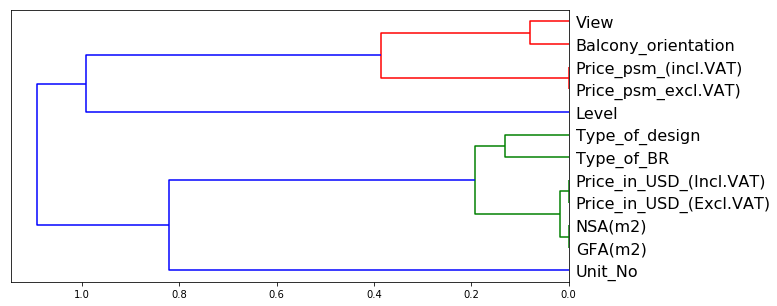

In [19]:
ddg.plot()

# learner

In [20]:
learner = LGBLearner()
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [21]:
learner.fit(params, *ds.trn, *ds.val, save = True)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 2.21054e-05	valid_1's l2: 5.63356e-05
Did not meet early stopping. Best iteration is:
[100]	training's l2: 2.21054e-05	valid_1's l2: 5.63356e-05


# interpretation

In [22]:
Shap = Shapley.from_Tree(learner, ds, ds.n_trn-5)

## ứng với từng bản ghi

In [23]:
Shap.one_force_plot(loc = 0)

In [24]:
Shap.one_force_plot(loc = 1)

## ứng với từng biến

In [31]:
ds.features

Index(['Level', 'Type_of_BR', 'Type_of_design', 'Unit_No',
       'Balcony_orientation', 'View', 'GFA(m2)', 'NSA(m2)',
       'Price_in_USD_(Excl.VAT)', 'Price_in_USD_(Incl.VAT)',
       'Price_psm_excl.VAT)', 'Price_psm_(incl.VAT)'],
      dtype='object')

### các trường không ảnh hướng tới giá nhà

In [ ]:
Tầng, số phòng ngủ, kiểu thiết kế căn hộ, Hướng ban công, Hướng cảnh quan (hướng sông, hướng nội khu), diện tích thông thủy

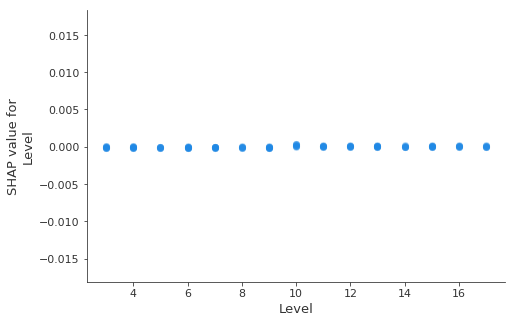

In [35]:
Shap.dependence_plot('Level', None)

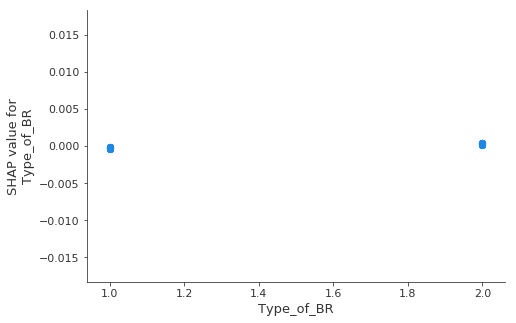

In [36]:
Shap.dependence_plot('Type_of_BR', None)

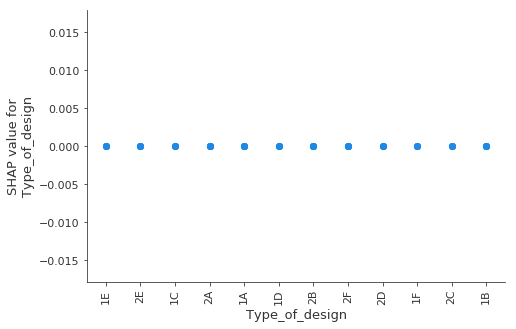

In [37]:
Shap.dependence_plot('Type_of_design', None)

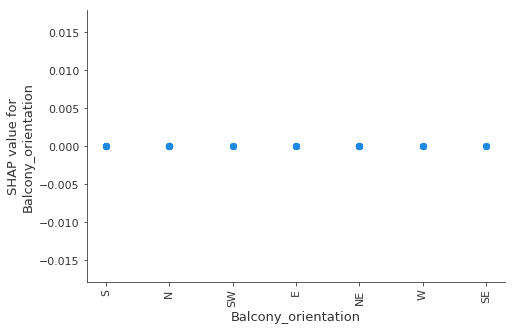

In [38]:
Shap.dependence_plot('Balcony_orientation', None)

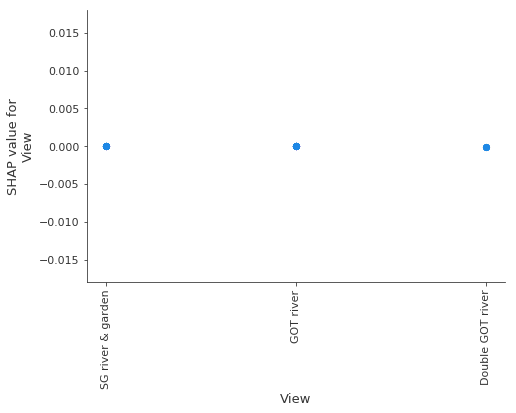

In [39]:
Shap.dependence_plot('View', None)

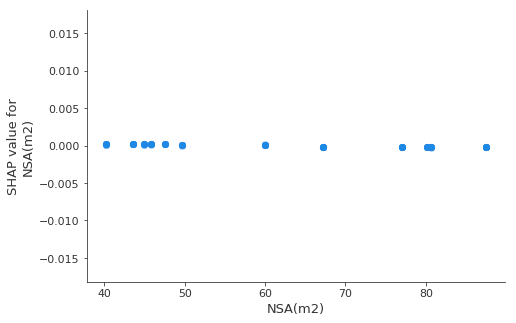

In [40]:
Shap.dependence_plot('NSA(m2)', None)

### Các trường có ít ảnh hưởng

Số phòng có ảnh hưởng tiêu cực, các phòng càng có số lớn thì càng gần bên trong nên giá thấp?

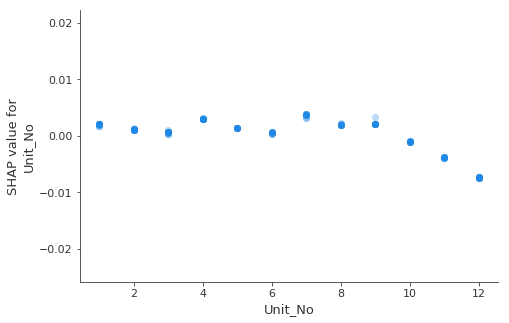

In [41]:
Shap.dependence_plot('Unit_No', None)

Diện tích xây dựng, diện tích nhỏ thì k có xu hướng cao hơn, trong khi diện tịch lớn thì k giảm. Hơi khó hiểu.

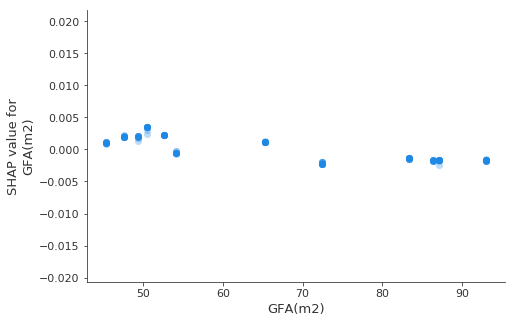

In [42]:
Shap.dependence_plot('GFA(m2)', None)

Giá căn hộ ???/

In [ ]:
'Price_in_USD_(Excl.VAT)', 'Price_in_USD_(Incl.VAT)'

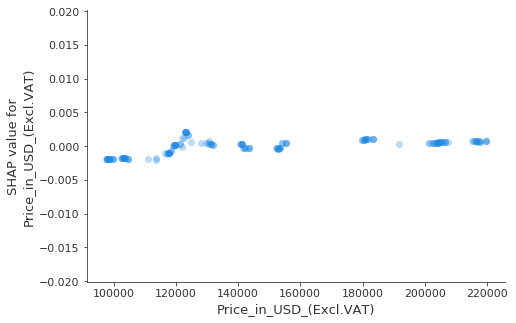

In [44]:
Shap.dependence_plot('Price_in_USD_(Excl.VAT)', None)

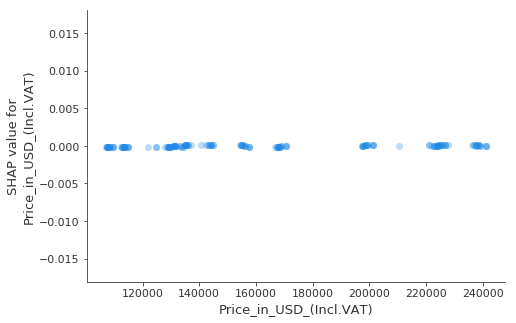

In [45]:
Shap.dependence_plot('Price_in_USD_(Incl.VAT)', None)

### Các trườn ảnh hưởng nhiều

Nhìn chung giá trung bình càng tăng thì k càng tăng.

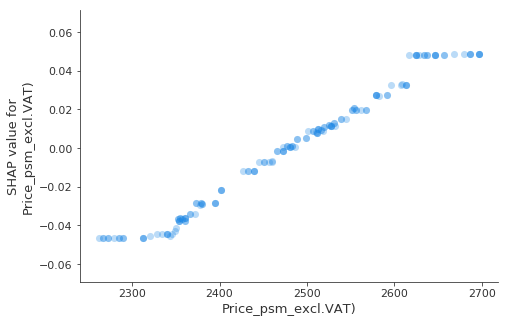

In [25]:
Shap.dependence_plot('Price_psm_excl.VAT)', None)

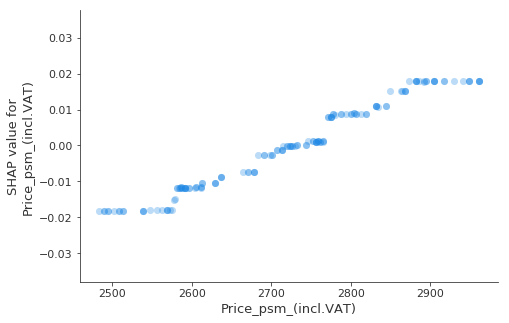

In [26]:
Shap.dependence_plot('Price_psm_(incl.VAT)', None)